In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('data/Eartquakes-1990-2023.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/Eartquakes-1990-2023.csv'

In [3]:
df.columns

Index(['time', 'place', 'status', 'tsunami', 'significance', 'data_type',
       'magnitudo', 'state', 'longitude', 'latitude', 'depth', 'date'],
      dtype='object')

In [4]:
df.describe()

,time,tsunami,significance,magnitudo,longitude,latitude,depth
count,3.445751e+06,3.445751e+06,3.445751e+06,3.445751e+06,3.445751e+06,3.445751e+06,3.445751e+06
mean,1.247124e+12,4.434447e-04,7.400973e+01,1.774076e+00,-1.012876e+02,3.746483e+01,2.285387e+01
std,2.976292e+11,2.105346e-02,1.016364e+02,1.291055e+00,7.697416e+01,2.041577e+01,5.484938e+01
min,6.311534e+11,0.000000e+00,0.000000e+00,-9.990000e+00,-1.799997e+02,-8.442200e+01,-1.000000e+01
25%,1.024401e+12,0.000000e+00,1.300000e+01,9.100000e-01,-1.464274e+02,3.406400e+01,3.120000e+00
50%,1.282338e+12,0.000000e+00,3.300000e+01,1.460000e+00,-1.189538e+02,3.793567e+01,7.700000e+00
75%,1.508701e+12,0.000000e+00,8.100000e+01,2.300000e+00,-1.159277e+02,4.784800e+01,1.612000e+01
max,1.690629e+12,1.000000e+00,2.910000e+03,9.100000e+00,1.800000e+02,8.738600e+01,7.358000e+02


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3445751 entries, 0 to 3445750
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time          int64  
 1   place         object 
 2   status        object 
 3   tsunami       int64  
 4   significance  int64  
 5   data_type     object 
 6   magnitudo     float64
 7   state         object 
 8   longitude     float64
 9   latitude      float64
 10  depth         float64
 11  date          object 
dtypes: float64(4), int64(3), object(5)
memory usage: 315.5+ MB


In [6]:
unique_values = df.nunique()
unique_values

time            3428775
place            531130
status                6
tsunami               2
significance       1170
data_type            25
magnitudo           933
state               858
longitude        733599
latitude         518295
depth             78386
date            3428775
dtype: int64

In [7]:
df.isna().sum()

time            0
place           0
status          0
tsunami         0
significance    0
data_type       0
magnitudo       0
state           0
longitude       0
latitude        0
depth           0
date            0
dtype: int64

In [8]:
duplicate_rows = df[df.duplicated(keep='first')]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

Number of duplicate rows: 16869


In [9]:
df.drop_duplicates(keep='first', inplace=True)

In [10]:
df['date'] = pd.to_datetime(df['date'], format='mixed')
df = df.set_index('date').sort_index()

In [11]:
df = df.drop(columns=['time', 'place', 'status', 'data_type'])

In [12]:
df = df.rename(columns={'magnitudo': 'magnitude'})

In [13]:
# one-hot encoding for states
df = pd.get_dummies(df, columns=['state'])

In [14]:
features_to_scale = ['significance', 'magnitude', 'longitude', 'latitude', 'depth']

features_to_scale.extend([col for col in df.columns if col.startswith('state_')])
scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [15]:
df.to_parquet('data/cleaned_data.parquet')

### Visualizations

In [14]:
df = df.reset_index()

In [15]:
filtered_magnitudo = df[df['magnitude'] > 7]

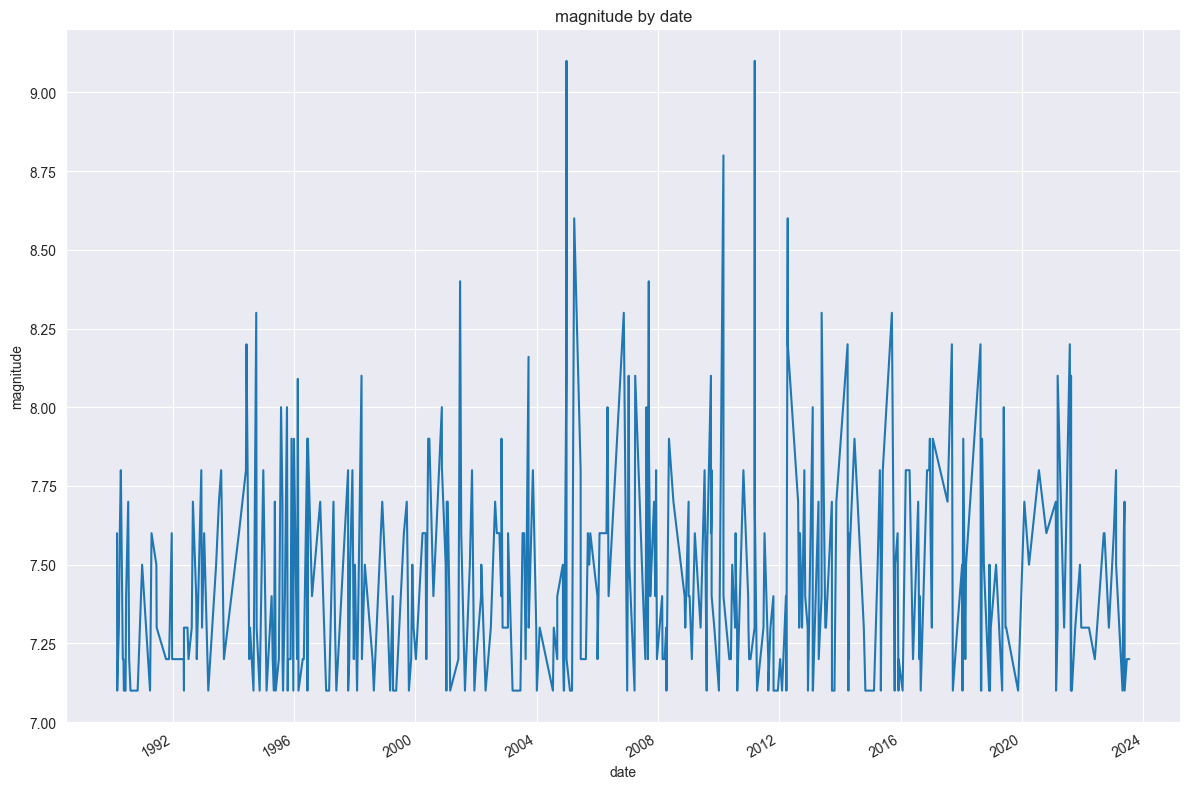

In [16]:
magnitudo_date = filtered_magnitudo.groupby('date', as_index=False)['magnitude'].sum()

# ensure datetime and sort for a proper time series plot
magnitudo_date['date'] = pd.to_datetime(magnitudo_date['date'], errors='coerce')
magnitudo_date = magnitudo_date.dropna(subset=['date']).sort_values('date')

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(magnitudo_date['date'], magnitudo_date['magnitude'])
ax.set_title('magnitude by date')
ax.set_xlabel('date')
ax.set_ylabel('magnitude')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [17]:
def transform_date(df):
    df = df.copy()
    df["hour"] = df.date.dt.hour
    df["day_of_month"] = df.date.dt.day
    df["weekday"] = df.date.dt.day_name()
    df["month"] = df.date.dt.month
    df["month_name"] = df.date.dt.month_name()
    df["year"] =df.date.dt.year
    return df

In [18]:
df = transform_date(df)

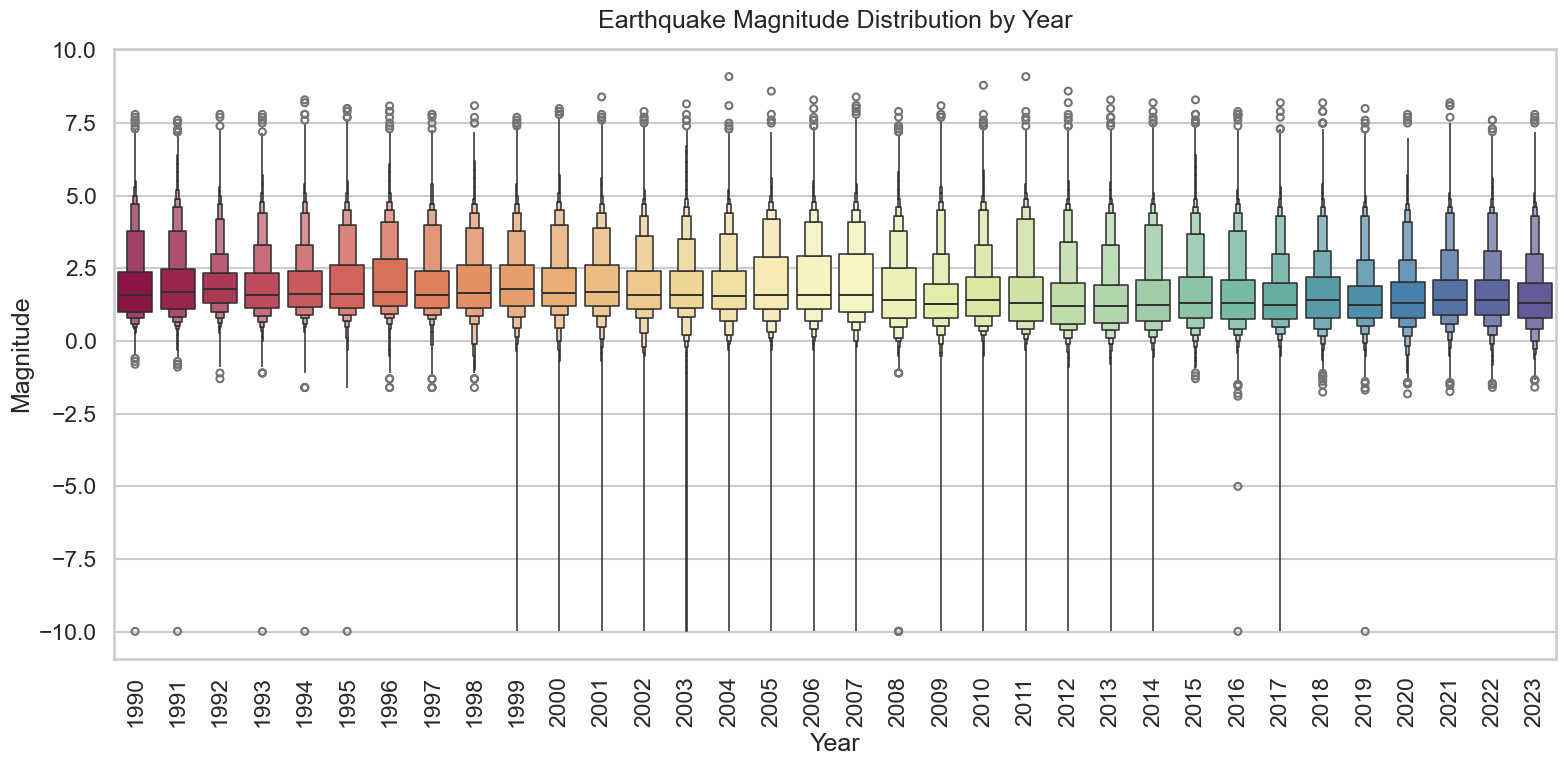

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(16, 8))
sns.boxenplot(data=df, x="year", y="magnitude", hue="year", palette="Spectral", legend=False)

plt.xticks(rotation=90)
plt.title("Earthquake Magnitude Distribution by Year", pad=15)
plt.xlabel("Year")
plt.ylabel("Magnitude")
plt.tight_layout()
plt.show()

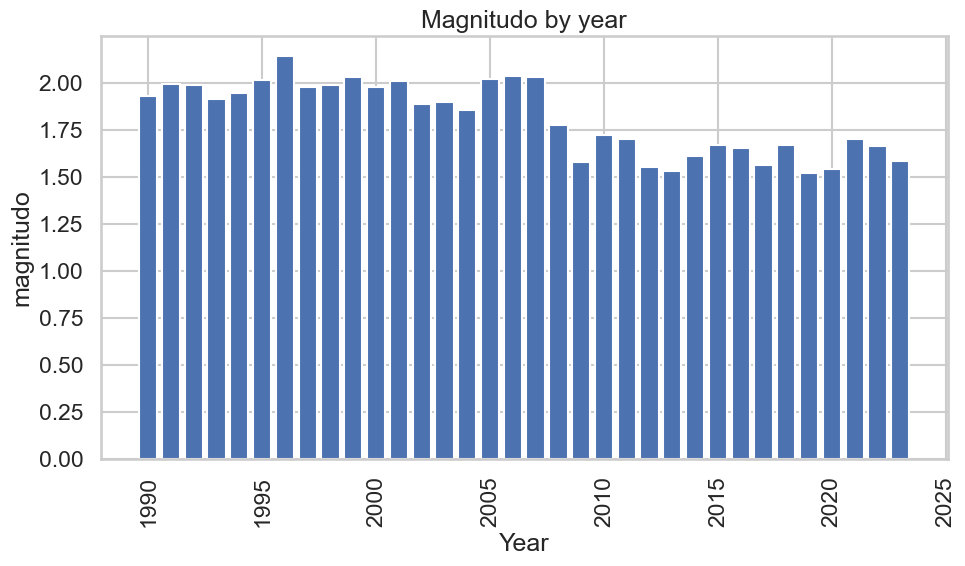

In [20]:
magnitudo_by_year = df.groupby('year', as_index=False)['magnitude'].mean().sort_values('year')

plt.figure(figsize=(10, 6))
plt.bar(magnitudo_by_year['year'], magnitudo_by_year['magnitude'])
plt.title('Magnitudo by year')
plt.xlabel('Year')
plt.ylabel('magnitudo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

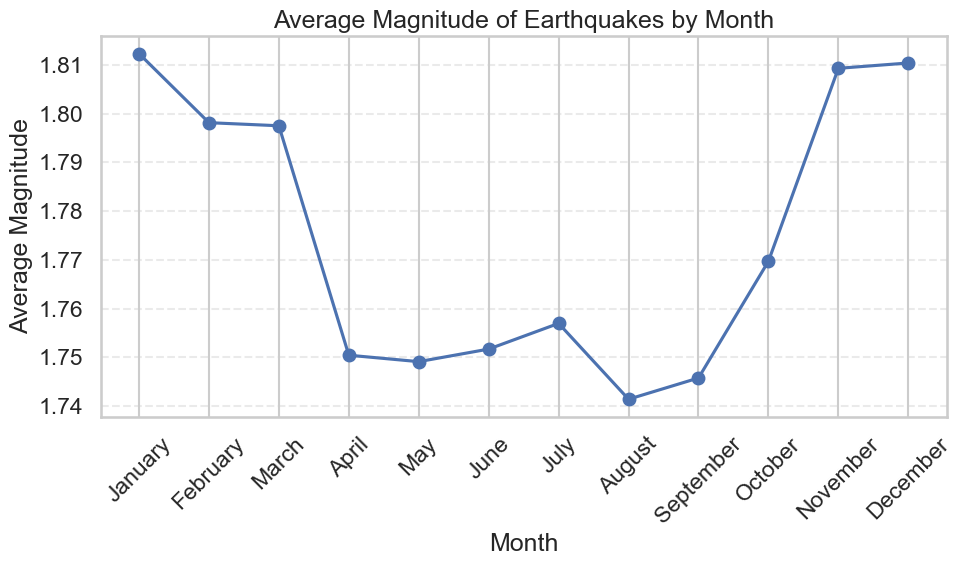

In [21]:
import calendar

magnitude_by_month = (
    df.groupby('month', as_index=False)['magnitude']
      .mean()
      .query('month >= 1 and month <= 12')
      .sort_values('month')
)

month_labels = [calendar.month_name[m] for m in magnitude_by_month['month']]

plt.figure(figsize=(10, 6))
plt.plot(magnitude_by_month['month'], magnitude_by_month['magnitude'], marker='o')
plt.title('Average Magnitude of Earthquakes by Month')
plt.xlabel('Month')
plt.ylabel('Average Magnitude')
plt.xticks(ticks=magnitude_by_month['month'], labels=month_labels, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()